In [1]:
#import torch
import os, sys, re, time
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

134601


In [2]:
import cv2
from ChromAn.src.file_io.data_organization import search_fovs_in_folders, Color_Usage
from ChromAn.src.segmentation_tools.cells import Align_Segmentation

In [3]:
import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation
from copy import copy

In [4]:
# Cellpose 
from cellpose import models

## Folders

In [16]:
# data_folder
data_folder = r'/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5'
# correction
correction_folder = r'/lab/weissman_imaging/puzheng/Corrections/20240401-Merscope01_s11_n1200'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    print(segmentation_save_folder)
    os.makedirs(segmentation_save_folder)
watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

In [6]:
# transpose with microscope
parameter_folder = r'/lab/weissman_imaging/puzheng/Softwares/Weissman_MERFISH_Scripts/merlin_parameters'
microscope_file = os.path.join(parameter_folder, 'microscope', 'merscope01_microscope.json')
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.107,
 'image_dimensions': [2304, 2304]}

In [8]:
# search folders
folders, fovs = search_fovs_in_folders(data_folder)
# Color usage file marks the organization of imaging files
color_usage_filename = os.path.join(data_folder, 'Analysis', 'color_usage_MF5.csv')
color_usage_df = Color_Usage(color_usage_filename)

- searching in folder: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5
-- 13 folders, 128 fovs detected.
- load color_usage from file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Analysis/color_usage_MF5.csv


In [9]:
# from color_usage, find dapi / polyt / fiducial
dapi_info = color_usage_df.get_dapi_info()[0]
polyt_info = color_usage_df.get_polyt_info()[0]
fiducial_channel = color_usage_df.get_fiducial_channel(color_usage_df)
print(dapi_info, polyt_info, fiducial_channel)

{'hyb': 'H0M1', 'channel': '405'} {'channel': '637', 'hyb': 'H12M13'} 477


# Run segmentation

In [10]:
from ChromAn.src.file_io.dax_process import DaxProcesser
from ChromAn.src.visual_tools.interactive import imshow_mark_3d
from merlin.analysis.segment import CellPoseSegment

In [11]:
from importlib import reload

In [12]:
import ChromAn
reload(ChromAn.src.file_io.dax_process)

<module 'ChromAn.src.file_io.dax_process' from '/lab/weissman_imaging/puzheng/Softwares/ChromAn/src/file_io/dax_process.py'>

In [ ]:

for _fov_id, _fov_name in enumerate(fovs):


    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(seg_save_file):
        print(f"Segmentation label file: {seg_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    #_ref_cls._corr_illumination()
    _ref_im = getattr(_ref_cls, f'im_{fiducial_channel}')
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls.ref_correction_channel = '637'
    #_cls._corr_illumination()
    _cls._calculate_drift(_ref_im, )
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    
    _dapi_im = getattr(_ref_cls, f"im_{dapi_info['channel']}")
    _polyt_im = getattr(_cls, f"im_{polyt_info['channel']}")
    # Run segmentation if target file not exist:
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- apply microscope corrections")
        dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
        polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

        # Create cellpose model
        print(f"- run Cellpose segmentation", end=' ')
        _cellpose_start = time.time()
        seg_model = models.CellposeModel(gpu=True, model_type='TN2')
        # Run cellpose prediction
        labels3d, _, _ = seg_model.eval(np.stack([polyt_im, dapi_im], axis=3), 
                                        #batch_size=60, #anisotropy=250/108,
                                        anisotropy=1200/108,
                                        cellprob_threshold=0, 
                                        channels=[1,2], 
                                        diameter=50, 
                                        min_size=2000,
                                        do_3D=False,
                                        )
        print(f"in {time.time()-_cellpose_start:.3f}s.")

        # convert to corrected labels
        corr_labels3d = CellPoseSegment.combine_2d_segmentation_masks_into_3d(labels3d)

        # save this segmentation mask
        print(f"- save to {np.max(corr_labels3d)} labels to file: {seg_save_file}")
        np.save(seg_save_file.split('.npy')[0], corr_labels3d, )
    
    

reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_000.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_000.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_000.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_000_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.143s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_000.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_000_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.360s.
+ Calculate

<IPython.core.display.Javascript object>


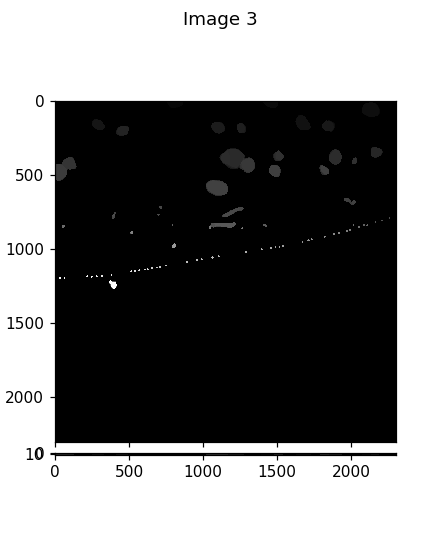

In [14]:
%matplotlib notebook
imshow_mark_3d([_dapi_im, _polyt_im, labels3d, corr_labels3d])

In [35]:
?copyfile

# STEP2: Watershed: Optional, potentially make it worse

In [19]:
fiducial_channel

'477'

In [23]:
watershed_th = 1.6

for _fov_id, _fov_name in enumerate(fovs):
    

    _save_id = _fov_id 
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
    # Load segmentation
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- seg file: {seg_save_file} has not been generated yet, skip. ")
        continue
        
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    _ref_cls._corr_illumination()
    _ref_im = getattr(_ref_cls, f'im_{fiducial_channel}')
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    # extract images
    _dapi_im = copy(getattr(_ref_cls, f"im_{dapi_info['channel']}"))
    _polyt_im = copy(getattr(_cls, f"im_{polyt_info['channel']}"))
    
    
    _save_id = _fov_id 

    dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

    # Prepare watershed
    print(f"- run watershed", end=' ')
    _watershed_start = time.time()
    water_input_im = polyt_im
    waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, watershed_th)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    print(f"in {time.time()-_watershed_start:.3f}s.")

    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )
    
    #break

- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_0.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_000.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_000.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_000.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_000_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 0.333s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2

reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_003.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_003.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_003.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_003_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.891s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.941s.
-- corrected illu

- Loaded images for channels:['477', '405'] in 1.989s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.950s.
-- corrected illumination for channel 405 in 0.781s.
- Finished illumination correction in 1.781s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_006.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_006_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.068s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_il

-- corrected illumination for channel 477 in 0.952s.
-- corrected illumination for channel 405 in 0.787s.
- Finished illumination correction in 1.782s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_009.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_009_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.091s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.946s.
-- corrected illumination for channel 477 in 0.788s.
- Finished illumination correction in 1.773s.

-- corrected illumination for channel 405 in 0.779s.
- Finished illumination correction in 1.762s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_012.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_012_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.061s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.938s.
-- corrected illumination for channel 477 in 0.780s.
- Finished illumination correction in 1.758s.
+ Calculate drift with fiducial_channel: 477
-- star

- Loaded images for channels:['637', '477'] in 1.086s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.850s.
-- corrected illumination for channel 477 in 0.779s.
- Finished illumination correction in 1.669s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.00e-02  5.87e+00 -1.10e+01] in 0.447s.
-- drift 1: [-1.000e-02  5.940e+00 -1.101e+01] in 0.460s.
-- drift 2: [-1.000e-02  5.920e+00 -1.097e+01] in 0.455s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.64

-- corrected illumination for channel 637 in 0.947s.
-- corrected illumination for channel 477 in 0.784s.
- Finished illumination correction in 1.781s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02  5.420e+00 -1.126e+01] in 0.443s.
-- drift 1: [-1.000e-02  5.370e+00 -1.118e+01] in 0.460s.
-- drift 2: [-1.000e-02  5.360e+00 -1.122e+01] in 0.455s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.637s.
- Finished warp correction in 8.637s.
- run watershed in 154.191s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/watershed/segmentation_label_18.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_19.npy
reference image: /lab/weissman_imagi

-- corrected illumination for channel 477 in 0.784s.
- Finished illumination correction in 1.781s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ -0.02   4.55 -11.09] in 0.447s.
-- drift 1: [-1.000e-02  4.430e+00 -1.099e+01] in 0.463s.
-- drift 2: [ -0.02   4.43 -11.14] in 0.457s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.641s.
- Finished warp correction in 8.641s.
- run watershed in 140.172s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/watershed/segmentation_label_21.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_22.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_022.dax
PolyT

-- drift 0: [  0.     4.91 -10.98] in 0.447s.
-- drift 1: [  0.     4.85 -10.88] in 0.462s.
-- drift 2: [-1.000e-02  4.910e+00 -1.092e+01] in 0.457s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.667s.
- Finished warp correction in 8.667s.
- run watershed in 151.794s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/watershed/segmentation_label_24.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_25.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_025.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_025.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_M

-- drift 1: [  0.     5.63 -11.55] in 0.454s.
-- drift 2: [  0.     5.62 -11.67] in 0.454s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.608s.
- Finished warp correction in 8.608s.
- run watershed in 133.207s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/watershed/segmentation_label_27.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_28.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_028.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_028.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_028.dax
- New save file: /lab/weissman_

-- drift 2: [-1.000e-02  5.420e+00 -1.102e+01] in 0.458s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.635s.
- Finished warp correction in 8.635s.
- run watershed in 137.436s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/watershed/segmentation_label_30.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_31.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_031.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_031.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_031.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-U

-- corrected warp for channel 637 in 8.687s.
- Finished warp correction in 8.687s.
- run watershed in 143.447s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/watershed/segmentation_label_33.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_34.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_034.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_034.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_034.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_034_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.916s.
- Correct ill

- run watershed in 149.615s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/watershed/segmentation_label_36.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_37.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_037.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_037.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_037.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_037_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.018s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_il

- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_40.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_040.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_040.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_040.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_040_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.131s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_

reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_043.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_043.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_043.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_043_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.873s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.924s.
-- corrected illu

- Loaded images for channels:['477', '405'] in 1.911s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.941s.
-- corrected illumination for channel 405 in 0.774s.
- Finished illumination correction in 1.765s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_046.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_046_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.124s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_il

-- corrected illumination for channel 477 in 0.943s.
-- corrected illumination for channel 405 in 0.772s.
- Finished illumination correction in 1.755s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_049.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_049_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.566s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.942s.
-- corrected illumination for channel 477 in 0.780s.
- Finished illumination correction in 1.762s.

-- corrected illumination for channel 405 in 0.777s.
- Finished illumination correction in 1.771s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_052.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_052_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.054s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.938s.
-- corrected illumination for channel 477 in 0.778s.
- Finished illumination correction in 1.764s.
+ Calculate drift with fiducial_channel: 477
-- star

- Loaded images for channels:['637', '477'] in 1.035s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.940s.
-- corrected illumination for channel 477 in 0.773s.
- Finished illumination correction in 1.761s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ -0.02   4.88 -11.27] in 1.794s.
-- drift 1: [-1.000e-02  4.860e+00 -1.116e+01] in 0.456s.
-- drift 2: [-1.000e-02  4.890e+00 -1.129e+01] in 0.459s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.613s.
- Fin

-- corrected illumination for channel 637 in 0.933s.
-- corrected illumination for channel 477 in 0.782s.
- Finished illumination correction in 1.766s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02  4.580e+00 -1.014e+01] in 0.447s.
-- drift 1: [  0.     4.56 -10.06] in 0.455s.
-- drift 2: [  0.     4.6  -10.14] in 0.455s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.749s.
- Finished warp correction in 8.749s.
- run watershed in 138.461s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/watershed/segmentation_label_58.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_59.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240

-- corrected illumination for channel 477 in 0.786s.
- Finished illumination correction in 1.781s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02  4.270e+00 -1.043e+01] in 0.446s.
-- drift 1: [-1.00e-02  4.23e+00 -1.04e+01] in 0.455s.
-- drift 2: [  0.     4.3  -10.51] in 0.458s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.749s.
- Finished warp correction in 8.749s.
- run watershed in 159.790s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/watershed/segmentation_label_61.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_62.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_062.

-- drift 0: [ -0.02   4.94 -11.49] in 0.442s.
-- drift 1: [-1.000e-02  4.990e+00 -1.144e+01] in 0.453s.
-- drift 2: [-1.00e-02  5.01e+00 -1.14e+01] in 0.457s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.729s.
- Finished warp correction in 8.729s.
- run watershed in 161.837s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/watershed/segmentation_label_64.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_65.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_065.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_065.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreate

-- drift 0: [-1.000e-02  3.990e+00 -1.054e+01] in 0.441s.
-- drift 1: [  0.     3.92 -10.58] in 0.459s.
-- drift 2: [-1.000e-02  4.000e+00 -1.059e+01] in 0.457s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.743s.
- Finished warp correction in 8.743s.
- run watershed in 144.363s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/watershed/segmentation_label_67.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_68.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_068.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_068.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untre

-- drift 1: [  0.     5.53 -11.4 ] in 0.463s.
-- drift 2: [  0.     5.55 -11.43] in 0.454s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.732s.
- Finished warp correction in 8.732s.
- run watershed in 105.065s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/watershed/segmentation_label_70.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_71.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_071.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_071.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_071.dax
- New save file: /lab/weissman_

-- drift 2: [  0.     5.15 -11.72] in 0.460s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.746s.
- Finished warp correction in 8.746s.
- run watershed in 142.347s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/watershed/segmentation_label_73.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_74.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_074.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_074.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_074.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spi

-- corrected warp for channel 637 in 8.762s.
- Finished warp correction in 8.762s.
- run watershed in 99.561s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/watershed/segmentation_label_76.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_77.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_077.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_077.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_077.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_077_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.689s.
- Correct illu

- run watershed in 87.583s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/watershed/segmentation_label_79.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_80.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_080.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_080.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_080.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_080_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.762s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_ill

- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_83.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_083.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_083.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_083.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_083_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.868s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_

reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_086.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_086.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_086.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_086_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.826s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.946s.
-- corrected illu

- Loaded images for channels:['477', '405'] in 1.953s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.945s.
-- corrected illumination for channel 405 in 0.777s.
- Finished illumination correction in 1.762s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_089.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_089_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.057s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_il

-- corrected illumination for channel 477 in 0.936s.
-- corrected illumination for channel 405 in 0.778s.
- Finished illumination correction in 1.764s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_092.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_092_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.119s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.949s.
-- corrected illumination for channel 477 in 0.785s.
- Finished illumination correction in 1.785s.

- Loaded images for channels:['637', '477'] in 1.247s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.956s.
-- corrected illumination for channel 477 in 0.794s.
- Finished illumination correction in 1.801s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.01  2.49 -9.61] in 0.446s.
-- drift 1: [ 0.    3.06 -9.42] in 0.457s.
-- drift 2: [ 0.01  2.79 -9.6 ] in 0.462s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.767s.
- Finished warp correction in 8.768s.


-- corrected illumination for channel 637 in 0.949s.
-- corrected illumination for channel 477 in 0.783s.
- Finished illumination correction in 1.783s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [  0.     2.29 -11.13] in 0.445s.
-- drift 1: [  0.     2.37 -11.1 ] in 0.457s.
-- drift 2: [  0.     2.3  -11.09] in 0.457s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.738s.
- Finished warp correction in 8.738s.
- run watershed in 155.995s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/watershed/segmentation_label_98.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_99.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreate

-- drift 0: [-1.000e-02  2.340e+00 -1.127e+01] in 0.443s.
-- drift 1: [  0.03   2.12 -11.33] in 0.461s.
-- drift 2: [  0.04   2.31 -11.35] in 0.453s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.755s.
- Finished warp correction in 8.755s.
- run watershed in 115.096s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/watershed/segmentation_label_101.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_102.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_102.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_102.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine

-- drift 1: [ 0.    2.93 -8.9 ] in 0.453s.
-- drift 2: [ 0.    2.84 -9.09] in 0.461s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.742s.
- Finished warp correction in 8.742s.
- run watershed in 115.225s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/watershed/segmentation_label_104.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_105.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_105.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_105.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_105.dax
- New save file: /lab/weissman_imag

-- corrected warp for channel 637 in 8.731s.
- Finished warp correction in 8.731s.
- run watershed in 146.224s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/watershed/segmentation_label_107.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_108.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_108.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_108.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_108.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_108_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.734s.
- Correct i

- run watershed in 133.264s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/watershed/segmentation_label_110.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_111.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_111.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_111.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_111.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_111_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.956s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_

- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/Segmentation/segmentation_label_114.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_114.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_114.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_114.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_114_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.779s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477

reference image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_117.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_117.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_117.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H0M1/Conv_zscan_117_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.924s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.957s.
-- corrected illu

- Loaded images for channels:['477', '405'] in 2.057s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.947s.
-- corrected illumination for channel 405 in 0.781s.
- Finished illumination correction in 1.768s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_120.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_120_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.172s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_il

- Loaded images for channels:['477', '405'] in 1.936s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.950s.
-- corrected illumination for channel 405 in 0.784s.
- Finished illumination correction in 1.774s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_123.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_123_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.173s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_il

-- corrected illumination for channel 477 in 0.947s.
-- corrected illumination for channel 405 in 0.785s.
- Finished illumination correction in 1.773s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_126.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240404-Untreated_Spine_MF5/H12M13/Conv_zscan_126_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.131s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.918s.
-- corrected illumination for channel 477 in 0.786s.
- Finished illumination correction in 1.744s.

<IPython.core.display.Javascript object>


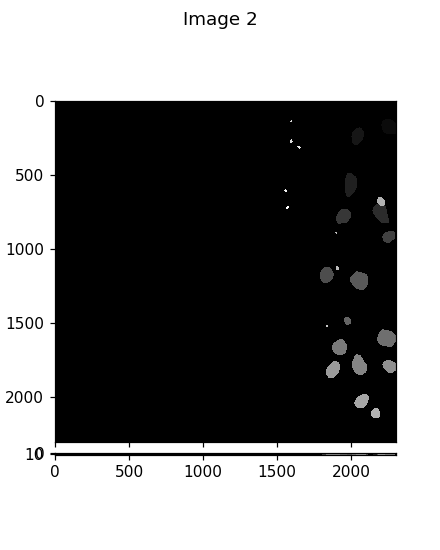

In [21]:
imshow_mark_3d([new_labels, corr_labels3d])

# Copy segmentation labels

In [24]:
# Copy segmentation labels
from shutil import copyfile
data_master_folder = r'/lab/weissman_imaging/puzheng/MERFISH_data'
analysis_master_folder = r'/lab/weissman_imaging/puzheng/MERFISH_analysis'
print(os.listdir(data_master_folder))
experiment_date = os.path.basename(data_folder).split('-')[0]
print(experiment_date)
for _fd in os.listdir(data_master_folder):
    if experiment_date in _fd:
        break
analysis_folder = os.path.join(analysis_master_folder, _fd)
print(analysis_folder)

['20240404-untreatedCord_MF5', '.DS_Store']
20240404
/lab/weissman_imaging/puzheng/MERFISH_analysis/20240404-untreatedCord_MF5


In [25]:
segmentation_target_folder = os.path.join(analysis_folder, 'CellPoseSegment', 'segmentation_label')
print(segmentation_target_folder)
if not os.path.exists(segmentation_target_folder):
    os.makedirs(segmentation_target_folder)
# copy
seg_label_filenames = [os.path.join(watershed_folder, _f) 
                       for _f in os.listdir(watershed_folder) 
                       if 'segmentation_label' in _f and '.npy' in _f]

for _f in seg_label_filenames:
    print(os.path.basename(_f))
    copyfile(_f, os.path.join(segmentation_target_folder, os.path.basename(_f)))

/lab/weissman_imaging/puzheng/MERFISH_analysis/20240404-untreatedCord_MF5/CellPoseSegment/segmentation_label
segmentation_label_0.npy
segmentation_label_1.npy
segmentation_label_2.npy
segmentation_label_3.npy
segmentation_label_4.npy
segmentation_label_5.npy
segmentation_label_6.npy
segmentation_label_7.npy
segmentation_label_8.npy
segmentation_label_9.npy
segmentation_label_10.npy
segmentation_label_11.npy
segmentation_label_12.npy
segmentation_label_13.npy
segmentation_label_14.npy
segmentation_label_15.npy
segmentation_label_16.npy
segmentation_label_17.npy
segmentation_label_18.npy
segmentation_label_19.npy
segmentation_label_20.npy
segmentation_label_21.npy
segmentation_label_22.npy
segmentation_label_23.npy
segmentation_label_24.npy
segmentation_label_25.npy
segmentation_label_26.npy
segmentation_label_27.npy
segmentation_label_28.npy
segmentation_label_29.npy
segmentation_label_30.npy
segmentation_label_31.npy
segmentation_label_32.npy
segmentation_label_33.npy
segmentation_labe

In [26]:
len(seg_label_filenames)

128

## visualize merlin_output_tif

In [12]:
import tifffile
ims = tifffile.imread(r'Z:\MERFISH_analysis\20230513-wtBrain_MO4\FiducialCorrelationWarp\images\aligned_fiducial_images30.tif')